In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import h5py

from tqdm import tqdm_notebook

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
import keras.backend as K

# Training

In [4]:
directory = './data/new_data_y/train_data/'

data = []

for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        data.append(gray_resize)
#         print(file)

data = np.array(data)

In [5]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.1)
del data

In [6]:
def train_gen(data, batch_size=128):
    while True:
        images = []
        for item in data:
            images.append(item/255.)
            
            if np.logical_or(len(images) >= batch_size, item == data[-1]).any():
                images_ar = np.array(images)
                images_ar = np.reshape(images_ar, (len(images_ar), 256, 256, 1))
                images = []
                yield (images_ar, images_ar)

In [7]:
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true)))

In [8]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(encoded_cnn)

encoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(encoded_cnn)

encoded_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_cnn)
encoded_cnn = MaxPooling2D((2, 2), padding='same')(encoded_cnn)


# Decoding
decoded_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_cnn)
decoded_cnn = UpSampling2D((2, 2))(decoded_cnn)

decoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_cnn)
decoded_cnn = UpSampling2D((2, 2))(decoded_cnn)

decoded_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_cnn)
decoded_cnn = UpSampling2D((2, 2))(decoded_cnn)

decoded_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_cnn)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Autoencoder
autoencoder_cnn = Model(input_image_cnn, decoded_cnn)

# Encoder
encoder_cnn = Model(input_image_cnn, encoded_cnn)

autoencoder_cnn.compile(optimizer='adadelta', loss=euclidean_distance_loss)

In [10]:
BATCH_SIZE = 128
EPOCHS = 20

history_cnn = autoencoder_cnn.fit_generator(train_gen(data_train, BATCH_SIZE),
               epochs=EPOCHS,
               steps_per_epoch = len(data_train) // BATCH_SIZE,
               validation_data = train_gen(data_test, BATCH_SIZE),
               validation_steps = len(data_test) // BATCH_SIZE)

Epoch 1/20
304/304 [==============================] - 96s 316ms/step - loss: 30.4576 - val_loss: 13.2631
Epoch 2/20
304/304 [==============================] - 92s 304ms/step - loss: 14.5524 - val_loss: 11.8610
Epoch 3/20
304/304 [==============================] - 89s 293ms/step - loss: 10.2774 - val_loss: 7.6783
Epoch 4/20
304/304 [==============================] - 90s 297ms/step - loss: 9.0401 - val_loss: 5.8895
Epoch 5/20
304/304 [==============================] - 90s 295ms/step - loss: 8.4832 - val_loss: 5.5228
Epoch 6/20
304/304 [==============================] - 88s 290ms/step - loss: 7.7195 - val_loss: 8.5081
Epoch 7/20
304/304 [==============================] - 90s 298ms/step - loss: 7.9568 - val_loss: 12.6431
Epoch 8/20
304/304 [==============================] - 91s 300ms/step - loss: 7.5778 - val_loss: 5.6823
Epoch 9/20
304/304 [==============================] - 97s 319ms/step - loss: 7.0984 - val_loss: 6.1384
Epoch 10/20
304/304 [==============================] - 99s 325ms/st

In [11]:
autoencoder_cnn.save_weights("./autoencoder_cnn_256_deep_euclidian.h5")
print("Saved model to disk")

Saved model to disk


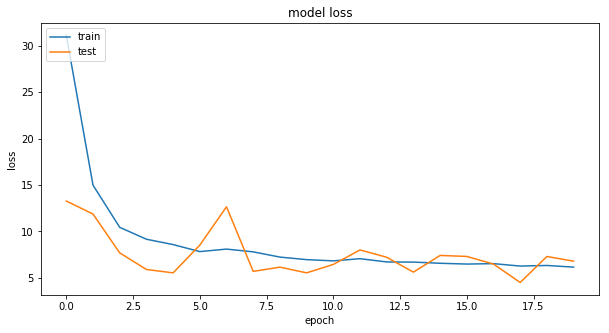

In [12]:
# Plotting learning curve
plt.figure(figsize=(10,5))
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Proxy testing
encoded_imgs_cnn = encoder_cnn.predict(np.reshape(data_test[:10, :, :, ]/255.,
                                                  (len(data_test[:10, :, :, ]), 256, 256, 1)))
decoded_imgs_cnn = autoencoder_cnn.predict(np.reshape(data_test[:10, :, :, ]/255.,
                                                  (len(data_test[:10, :, :, ]), 256, 256, 1)))

In [14]:
# Plotting the images (original - encoded - decoded)

plt.figure(figsize=(100, 300))
for i in range(10):
    # display original images
    ax = plt.subplot(18, 10, i + 1)
    plt.imshow((data_test[i]/255.).reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images (one per filter)
    for j in range(encoded_imgs_cnn.shape[3]):
        ax = plt.subplot(18, 10, i + j*10 + 1 + 10)
        plt.imshow(encoded_imgs_cnn[i,:,:,j].reshape(32,32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # display reconstructed images
    ax = plt.subplot(18, 10, 170 + i + 1)
    plt.imshow(decoded_imgs_cnn[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

# Evaluation and threshold identification

In [15]:
directory = './data/new_data_y/test_data/defective_pics/'

data_256_defect = []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data_256_defect.append(gray_resize/255.)

data_256_defect = np.reshape(data_256_defect, (len(data_256_defect), 256, 256, 1))

In [16]:
directory = './data/new_data_y/test_data/holdout_images/'

data_256_holdout= []
# i = 0
for file in tqdm_notebook(os.listdir(directory)):
    if file.endswith(".jpg"):
        img = cv2.imread(directory+file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_resize = cv2.resize(gray, (256, 256))
        
        data_256_holdout.append(gray_resize/255.)

data_256_holdout = np.reshape(data_256_holdout, (len(data_256_holdout), 256, 256, 1))

In [26]:
#Random seed
np.random.seed(42)

# Network architecture
input_image_256_cnn = Input(shape=(256, 256, 1))

# Encoding
encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)

encoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
encoded_256_cnn = MaxPooling2D((2, 2), padding='same')(encoded_256_cnn)



# Decoding
decoded_256_cnn = Conv2D(16, (5, 5), activation='relu', padding='same')(encoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(32, (5, 5), activation='relu', padding='same')(decoded_256_cnn)
decoded_256_cnn = UpSampling2D((2, 2))(decoded_256_cnn)

decoded_256_cnn = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(decoded_256_cnn)

In [27]:
# Autoencoder
autoencoder_256_cnn = Model(input_image_256_cnn, decoded_256_cnn)

# Encoder
encoder_256_cnn = Model(input_image_256_cnn, encoded_256_cnn)

autoencoder_256_cnn.compile(optimizer='adadelta', loss=euclidean_distance_loss)

In [28]:
# load weights into new model
autoencoder_256_cnn.load_weights("./application/static/index/autoencoder_cnn_256_deep_euclidian.h5")
print("Loaded model from disk")

Loaded model from disk


In [29]:
# Holdout images
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])

difference_mean = []
for i in range(data_256_holdout.shape[0]):
    diff = (data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_holdout.shape[0]):
    diff = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_holdout.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_holdout[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)

In [30]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-3.997319675844746, 1590.2296865912588, 45.34911626181586)

In [31]:
# Defected images
decoded_imgs_256_cnn = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])

difference_mean = []
for i in range(data_256_defect.shape[0]):
    diff = (data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.).mean()
    difference_mean.append(diff)
    
difference_linalg = []
for i in range(data_256_defect.shape[0]):
    diff = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn[i]*255.)
    difference_linalg.append(diff)
    
    
import sklearn.metrics as metrics

difference_mse = []
for i in range(data_256_defect.shape[0]):
    diff = metrics.mean_squared_error(np.reshape(decoded_imgs_256_cnn[i]*255., (256, 256)),
                                      np.reshape(data_256_defect[i, :, :, ]*255., (256, 256)))
    
    difference_mse.append(diff)

In [32]:
(np.mean(difference_mean), np.mean(difference_linalg), np.mean(difference_mse))

(-4.197518206051528, 1624.0843338917268, 44.770369910100094)

In [33]:
# Threshold identification
decoded_imgs_256_cnn_holdout = autoencoder_256_cnn.predict(data_256_holdout[:, :, :, ])
decoded_imgs_256_cnn_defect = autoencoder_256_cnn.predict(data_256_defect[:, :, :, ])


for threshold in range(1570,1640,5):
    total_diff_holdout = []
    anomalies_holdout = []
    
    for i in range(data_256_holdout.shape[0]):
        diff_2 = np.linalg.norm(data_256_holdout[i, :, :, ]*255. - decoded_imgs_256_cnn_holdout[i]*255.)

        if diff_2 >= threshold:
            anomalies_holdout.append(1)

    FP = np.sum(anomalies_holdout)
    TN = data_256_holdout.shape[0] - FP

    total_diff_defect = []
    anomalies_defect = []
    for i in range(data_256_defect.shape[0]):
        diff_2 = np.linalg.norm(data_256_defect[i, :, :, ]*255. - decoded_imgs_256_cnn_defect[i]*255.)

        if diff_2 >= threshold:
            anomalies_defect.append(1)

    TP = np.sum(anomalies_defect)
    FN = data_256_defect.shape[0] - TP

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2 * (precision*recall)/(precision+recall)

    print("Threshold: {0}".format(threshold))
    print("False positive: {0}".format(FP))
    print("True negative: {0}".format(TN))
    print("True positive: {0}".format(TP))
    print("False negative: {0}".format(FN))
    print("Precision: {0}".format(precision))
    print("Recall: {0}".format(recall))
    print("F1: {0}".format(F1))
    print("----------")

Threshold: 1570
False positive: 1084
True negative: 1193
True positive: 67
False negative: 59
Precision: 0.05821025195482189
Recall: 0.5317460317460317
F1: 0.10493343774471417
----------
Threshold: 1575
False positive: 1077
True negative: 1200
True positive: 67
False negative: 59
Precision: 0.05856643356643357
Recall: 0.5317460317460317
F1: 0.10551181102362206
----------
Threshold: 1580
False positive: 1075
True negative: 1202
True positive: 67
False negative: 59
Precision: 0.05866900175131348
Recall: 0.5317460317460317
F1: 0.10567823343848579
----------
Threshold: 1585
False positive: 1073
True negative: 1204
True positive: 67
False negative: 59
Precision: 0.058771929824561406
Recall: 0.5317460317460317
F1: 0.10584518167456558
----------
Threshold: 1590
False positive: 1072
True negative: 1205
True positive: 67
False negative: 59
Precision: 0.058823529411764705
Recall: 0.5317460317460317
F1: 0.10592885375494071
----------
Threshold: 1595
False positive: 1069
True negative: 1208
True p